In [26]:
%load_ext autoreload
%autoreload 2

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import torch
from torch.utils.data import DataLoader
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn

In [28]:
#!git clone https://github.com/LeoBrasileo/Aprendizaje-Automatico-TP2.git
import sys
sys.path.insert(0,'/content/Aprendizaje-Automatico-TP2')
sys.path.insert(0,'/content/Aprendizaje-Automatico-TP2/py')
sys.path.insert(0,'/content/Aprendizaje-Automatico-TP2/py/modelos')
sys.path.insert(0,'/content/Aprendizaje-Automatico-TP2/data')

In [29]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
 
# Defino el tamaño del vocabulario como el tamaño del vocabulario default de bert-base-multilingual-cased,
# Esto se usaría en las capas de embeddings, como dimensión.
VOCAB_SIZE = tokenizer.vocab_size

Definimos el dataset

In [45]:
from py.funciones_dataset import generar_datos_etiquetados, reconstruir_texto, DatasetBase, collate_fn

dataset_paths = [
    "data/datos_marquez.csv",
    "data/datos_google_argento.csv",
    "data/datos_preguntas_paises.csv"
]

datos_etiquetados_marquez = generar_datos_etiquetados(paths=["data/datos_marquez.csv"])
datos_etiquetados_google = generar_datos_etiquetados(paths=["data/datos_google_argento.csv"])

datos_etiquetados_completo = generar_datos_etiquetados(paths=dataset_paths)



Separamos en entrenamiento y held-out

In [40]:
datos_dev, datos_heldout = train_test_split(
    datos_etiquetados_completo,
    test_size=0.10,
    random_state=324
)

# Modelos

## Modelo clásico

Vamos a usar un Random Forest, no necesitamos la clase Dataset para esto porque solo queremos hacer una simple ingenieria de atributos.

Como el Random Forest no puede entender los contextos de la secuencialidad.
Lo que hacemos es aplanar los tokens del dataset y guardar atributos especiales para captar algunos patrones, como si un token es inicial, etc.
Por otro lado ahora el RF entiende de contexto a partir de una ventana parametrizable de los tokens anteriores y posteriores.

In [ ]:
from py.modelos.RF_Global import RF_Global

# armo un dataset flat de todos los datos
datos_dev_flat = [token for sentence in datos_dev for token in sentence]
datos_heldout_flat = [token for sentence in datos_heldout for token in sentence]

pd.DataFrame(datos_dev_flat).head()

,instancia_id,token,token_id,capitalizacion,puntuacion_inicial,puntuacion_final
0,9333,quién,61811,1,1,0
1,9333,sub,13987,0,0,0
2,9333,##ió,12343,0,0,0
3,9333,el,10125,0,0,0
4,9333,mejor,18345,0,0,0


Separo los datos, entreno el modelo y veamos como fue

In [ ]:
modelo = RF_Global(window_size=1)

modelo.fit(datos_dev_flat)

In [ ]:
caps_pred, punt_inic_pred, punt_fin_pred = modelo.predict(datos_heldout_flat)
frases_reconstruidas = reconstruir_texto(datos_heldout_flat, caps_pred, punt_inic_pred, punt_fin_pred)

for frase in frases_reconstruidas[:10]:
    print(frase)

Voy a hablar con la niña le dijo y vas a ver que te la sirvo en bandeja
¿Cuándo adquirirá Venezuela el derecho a voto en la organización
Los autos chicos normalmente ahorran más nafta
Te mando un beso y nos estamos viendo
Consideraba que ya había cedido demasiado al aceptar que abandonara el cuarto
Lola luna se defendía sinceramente con astucias de hembra sabia comadrejeando el escurridizo y flexible y fragante cuerpo de comadreja mientras trataba de destroncarle los ríñones con las rodillas, y le alacraneaba la cara con las uñas pero sin que él ni ella emitieran un suspiro que no pudiera confundirse con la respiración de alguien que contemplara el parsimonioso crepúsculo de abril por la ventana abierta
¿Qué necesitan las rosas para florecer
¿Quién subió el mejor video?
Las rosas simbolizan el amor
¿Sabes en donde van a ser los juegos olímpicos


In [ ]:
print(modelo.score(datos_heldout_flat))

(0.7466236054022314, 0.9119496855345912, 0.14210802307288936)


Evidentemente aprendio que las oraciones arrancan en mayuscula. Y parece que tambien aprendio cuando inician las preguntas.

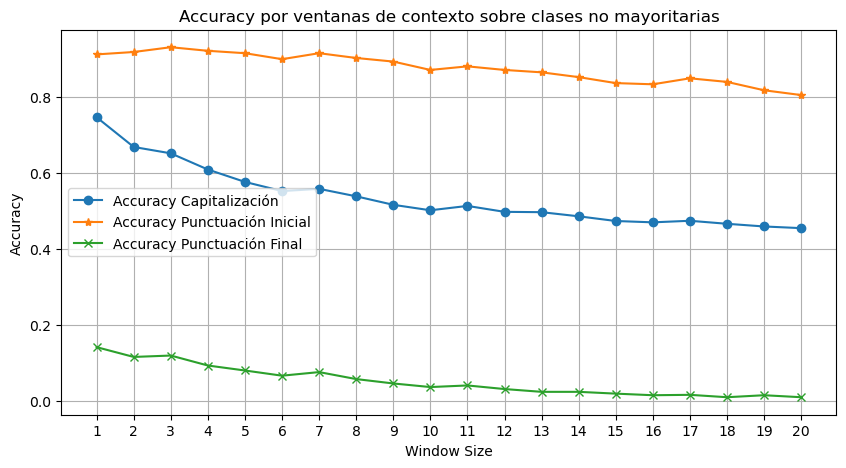

In [ ]:
scores_caps = []
scores_punt_inic = []
scores_punt_fin = []

windows = 20

for window_size in range(1, windows + 1):
    modelo = RF_Global(window_size=window_size)
    modelo.fit(datos_dev_flat)
    score_caps, score_punt_inic, score_punt_fin = modelo.score(datos_heldout_flat)

    scores_caps.append(score_caps)
    scores_punt_inic.append(score_punt_inic)
    scores_punt_fin.append(score_punt_fin)

plt.figure(figsize=(10, 5))
plt.plot(range(1, windows + 1), scores_caps, label='Accuracy Capitalización', marker='o')
plt.plot(range(1, windows + 1), scores_punt_inic, label='Accuracy Punctuación Inicial', marker='*')
plt.plot(range(1, windows + 1), scores_punt_fin, label='Accuracy Punctuación Final', marker='x')
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.title('Accuracy por ventanas de contexto sobre clases no mayoritarias')
plt.xticks(range(1, windows + 1))
plt.legend()
plt.grid()
plt.show()

## RNN Clásica y Bidireccional

In [49]:
from py.modelos.RNN_Clasica import RNN_Clasica
from py.modelos.RNN_Bidireccional import RNN_Bidireccional

In [50]:
from py.funciones_entrenamiento import entrenar_modelo

# Definición de modelos y entrenamiento

### Definición de modelos e hiperparámetros

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # placa nvidia
device = 'xpu:0' if torch.xpu.is_available() else device # placa intel

EMBEDDING_DIM = 768

### Entrenamiento

### Prueba unidireccional  curva de aprendizaje por tarea

In [ ]:
NUM_EPOCHS_UNI = 10
LEARNING_RATE_UNI = 0.0001
INPUT_SIZE_MAX = 150
HIDDEN_UNI = 368

modelo_unidireccional2 = RNN_Clasica(hidden_size=HIDDEN_UNI, vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, bert_embedding=True)
modelo_unidireccional2 = modelo_unidireccional2.to(device)

optimizer_unidireccional = torch.optim.AdamW(modelo_unidireccional2.parameters(), lr=LEARNING_RATE_UNI)
criterion_unidireccional = nn.CrossEntropyLoss()

print(f"Modelo de red neuronal unidireccional creado con {sum(p.numel() for p in modelo_unidireccional2.parameters())} parámetros")

Modelo de red neuronal unidireccional creado con 92506200 parámetros


In [ ]:
# separo 65% train, 35% validacion
train_data, val_data = train_test_split(
    datos_dev,
    test_size=0.3,
    random_state=42
)

print(f"Dataset completo: {len(datos_dev)} sentences")
print(f"Entrenamiento: {len(train_data)} sentences ({len(train_data)/len(datos_dev)*100:.1f}%)")
print(f"Validación: {len(val_data)} sentences ({len(val_data)/len(datos_dev)*100:.1f}%)")

# datasets
dataset_train = DatasetBase(data=train_data)
dataset_val = DatasetBase(data=val_data)

# loaders
loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=collate_fn)
loader_val = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=collate_fn)

modelo_unidireccional2 = modelo_unidireccional2.to(device)
train_losses, val_losses, punt_inicial_train_losses, punt_final_train_losses, punt_cap_train_losses, punt_inicial_val_losses, punt_final_val_losses, punt_cap_val_losses = entrenar_modelo   (modelo_unidireccional2, loader_train, loader_val,optimizer_unidireccional, criterion_unidireccional, cant_epochs=NUM_EPOCHS_UNI)

 

Dataset completo: 12629 sentences
Entrenamiento: 8208 sentences (65.0%)
Validación: 4421 sentences (35.0%)
Iniciando entrenamiento...
--------------------------------------------------
PredicciÃ³n puntuaciÃ³n inicial: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0

KeyboardInterrupt: 

In [ ]:
#Curva de aprendizaje por tarea
losses = [train_losses, val_losses, punt_inicial_val_losses, punt_final_val_losses, punt_cap_val_losses]
labels = ['train_losses', 'val_losses', 'punt_inicial_val_losses', 'punt_final_val_losses', 'punt_cap_val_losses']


plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)
step = 5

for loss_actual, label in zip(losses, labels):
    plt.semilogy(epochs[::step], loss_actual[::step], label=label, linewidth=1)

plt.semilogy(epochs[::step], train_losses[::step], 'b-', label='Pérdida Entrenamiento', linewidth=1)
plt.semilogy(epochs[::step], val_losses[::step], 'r-', label='Pérdida Validación', linewidth=1)

plt.title('Curva de Aprendizaje - Pérdida (Escala Log)')
plt.xlabel('Época')
plt.ylabel('Pérdida (log)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"\nResultados finales:")
print(f"Pérdida final de entrenamiento: {train_losses[-1]:.4f}")
print(f"Pérdida final de validación: {val_losses[-1]:.4f}")
print(f"Mejor pérdida de validación: {min(val_losses):.4f} (época {val_losses.index(min(val_losses)) + 1})")

NameError: name 'train_losses' is not defined

# Pruebas con bidireccional

In [ ]:
NUM_EPOCHS_BIDIREC = 20
LEARNING_RATE_BIDIREC = 0.0001
HIDDEN_SIZE = EMBEDDING_DIM

modelo_bidireccional = RNN_Bidireccional(embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE, hidden_size = HIDDEN_SIZE, num_layers=3)
modelo_bidireccional = modelo_bidireccional.to(device)

optimizer_bidireccional = torch.optim.AdamW(modelo_bidireccional.parameters(), lr=LEARNING_RATE_BIDIREC)
criterion_bidireccional = nn.CrossEntropyLoss()

print(f"Modelo de red neuronal bidireccional creado con {sum(p.numel() for p in modelo_bidireccional.parameters())} parámetros")

In [ ]:
# separo 65% train, 35% validacion
train_data, val_data = train_test_split(
    datos_dev,
    test_size=0.3,
    random_state=42
)

print(f"Dataset completo: {len(datos_dev)} sentences")
print(f"Entrenamiento: {len(train_data)} sentences ({len(train_data)/len(datos_dev)*100:.1f}%)")
print(f"Validación: {len(val_data)} sentences ({len(val_data)/len(datos_dev)*100:.1f}%)")

# datasets
dataset_train = DatasetBase(data=train_data)
dataset_val = DatasetBase(data=val_data)

# loaders
loader_train = DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=collate_fn)
loader_val = DataLoader(dataset_val, batch_size=16, shuffle=False, collate_fn=collate_fn)

modelo_bidireccional = modelo_bidireccional.to(device)
train_losses_bi, val_losses_bi, punt_inicial_train_losses_bi, punt_final_train_losses_bi, punt_cap_train_losses_bi, punt_inicial_val_losses_bi, punt_final_val_losses_bi, punt_cap_val_losses_bi = entrenar_modelo(
modelo_bidireccional, loader_train, loader_val, optimizer_bidireccional, criterion_bidireccional, cant_epochs=NUM_EPOCHS_BIDIREC)

Dataset completo: 12629 sentences
Entrenamiento: 8208 sentences (65.0%)
Validación: 4421 sentences (35.0%)
Iniciando entrenamiento...
--------------------------------------------------


KeyboardInterrupt: 

## 

In [ ]:
losses = [train_losses_bi, val_losses_bi, punt_inicial_val_losses_bi, punt_final_val_losses_bi, punt_cap_val_losses_bi]
labels = ['train_losses', 'val_losses', 'punt_inicial_val_losses', 'punt_final_val_losses', 'punt_cap_val_losses']


plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)
step = 5

for loss_actual, label in zip(losses, labels):
    plt.semilogy(epochs[::step], loss_actual[::step], label=label, linewidth=1)

plt.semilogy(epochs[::step], train_losses[::step], 'b-', label='Pérdida Entrenamiento', linewidth=1)
plt.semilogy(epochs[::step], val_losses[::step], 'r-', label='Pérdida Validación', linewidth=1)

plt.title('Curva de Aprendizaje - Pérdida (Escala Log)')
plt.xlabel('Época')
plt.ylabel('Pérdida (log)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"\nResultados finales:")
print(f"Pérdida final de entrenamiento: {train_losses[-1]:.4f}")
print(f"Pérdida final de validación: {val_losses[-1]:.4f}")
print(f"Mejor pérdida de validación: {min(val_losses):.4f} (época {val_losses.index(min(val_losses)) + 1})")